# Growing Neural Cellular Automata

This notebook contains code to reproduce experiments and figures for the Modeling Morphogenisis in 3d: Neural cellular Automata

In [ ]:
#@title Imports and Notebook Utilities
%tensorflow_version 2.x

import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

import tensorflow as tf

from IPython.display import Image, HTML, clear_output
import tqdm

import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
clear_output()

import csv
import numpy as np
from IPython.display import Image, HTML, clear_output
import matplotlib.pyplot as plt

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)


def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()


def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))



def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img




In [ ]:
#@title Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Define file path and dimension
#@markdown Choose for avilable 3d models
MODEL_3D = "bird-c_15x28x28.csv" #@param ["torus_19x6x19.csv", "coronavirus__35x34x35.csv", "bird-c_15x28x28.csv", "spider_29x10x31.csv", "bird_26x14x27.csv", "knight_18x8x15.csv"]
path = '/content/drive/MyDrive/voxel/'+MODEL_3D
#path='torus_19x6x19.csv'

file_name = path.split('/')[-1].split('.')[0]
dimention = [int(x) for x in file_name.split("_")[-1].split("x")]
print(dimention)
max_dim=int(max(dimention))

[15, 28, 28]


In [ ]:
#@title Read and load data 
with open(path, 'r') as f:
    reader = csv.reader(f)
    data = list(reader)
SIZE_X=dimention[0]
SIZE_Y=dimention[1]
SIZE_Z=dimention[2]

arr = np.array(data).astype(float)

In [ ]:
#@title Returns a single layer of voxel
def return_zLayer_t(arr,z_l):
  z= np.array([arr[arr[:, 2] ==  z_l]])
  Zxy=z[0][...,:6].astype(int)

  Z=np.zeros((SIZE_X,SIZE_Y))
  R=np.zeros((SIZE_X,SIZE_Y))
  G=np.zeros((SIZE_X,SIZE_Y))
  B=np.zeros((SIZE_X,SIZE_Y))

  increment=0

  for i in Zxy:
    Z[i[0]][i[1]]=1
    R[i[0]][i[1]]=i[3]
    G[i[0]][i[1]]=i[4]
    B[i[0]][i[1]]=i[5]
  return R,G,B,Z

In [ ]:
#@title Stack up layers 
r_stack,g_stack,b_stack,z_stack=return_zLayer_t(arr,0)
for i in range(1,SIZE_Z):
  r,g,b,a=return_zLayer_t(arr,i)
  r_stack = np.dstack((r_stack,r))
  g_stack = np.dstack((g_stack,g))
  b_stack = np.dstack((b_stack,b))
  z_stack = np.dstack((z_stack,a))

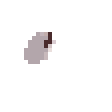

(28, 28, 4)


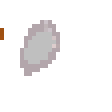

(28, 28, 4)


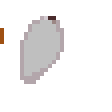

(28, 28, 4)


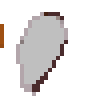

(28, 28, 4)


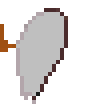

(28, 28, 4)


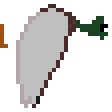

(28, 28, 4)


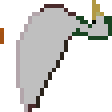

(28, 28, 4)


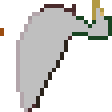

(28, 28, 4)


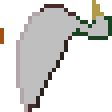

(28, 28, 4)


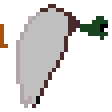

(28, 28, 4)


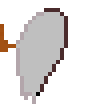

(28, 28, 4)


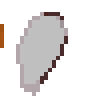

(28, 28, 4)


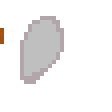

(28, 28, 4)


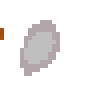

(28, 28, 4)


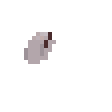

(28, 28, 4)


In [ ]:
#@title Display all layer
for i in range(SIZE_X):
  img= np.stack((r_stack[i]/255,g_stack[i]/255,b_stack[i]/255,z_stack[i]),axis=2)
  imshow(zoom(img))
  print(img.shape)


In [ ]:
#@title  Parameters
#@markdown Choose for options below
TRAINING_TYPE = "structure with color" #@param ["structure only", "structure with color"]
flag = True if TRAINING_TYPE == "structure with color" else False

FACE_COLOR='sienna'#@param['sienna','silver','dimgray','k']

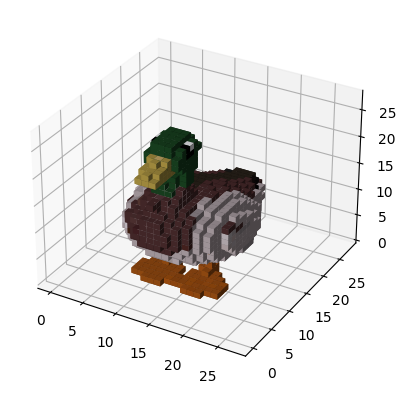

(15, 28, 28, 4)


In [ ]:
#@title Define target  { vertical-output: true}

target=np.stack((r_stack/255,g_stack/255,b_stack/255,z_stack),axis=-1)

z_resized = np.pad(z_stack, (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant')
r_resized = np.pad(r_stack, (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant')
g_resized = np.pad(g_stack, (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant')
b_resized = np.pad(b_stack, (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant')
target_resized=np.stack((r_resized/255,g_resized/255,b_resized/255,z_resized),axis=-1)

fig = plt.figure()
ax=fig.add_subplot(projection='3d')
if flag:

  ax.voxels(target_resized[...,3], facecolors=target_resized[..., :3] )
else:
  ax.voxels(target_resized[...,3], facecolors=FACE_COLOR)

# Show the plot
plt.show()
print(target.shape)

In [ ]:
#@title Defining seed for 3d
#@markdown Choose no of channel
NUMBER_OF_CHANNELS = "24" #@param {type:"string"}
Channel=int(NUMBER_OF_CHANNELS)
seed = np.zeros([1,SIZE_X,SIZE_Y,SIZE_Z,Channel],np.float32)
seed[:,SIZE_X//2,SIZE_Y//2,SIZE_Z//2,:3]=1
print("Shape of seed:")
print(seed.shape)


Shape of seed:
(1, 15, 28, 28, 24)


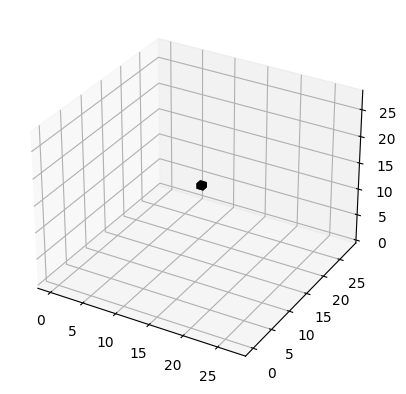

In [ ]:
#@title Display seed { vertical-output: true}
temp = seed[0][...,:4]
z_resized = np.pad(temp[...,0], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant')


fig = plt.figure()
ax=fig.add_subplot(projection='3d')
if flag:
  r_resized = np.pad(temp[...,1], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant')
  g_resized = np.pad(temp[...,2], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant')
  b_resized = np.pad(temp[...,3], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant')

  obj=np.stack((r_resized/255,g_resized/255,b_resized/255,z_resized),axis=-1)
  ax.voxels(obj[...,3], facecolors=obj[..., :3] )
else:
  ax.voxels(z_resized, facecolors=FACE_COLOR )

# Show the plot
plt.show()

Update step

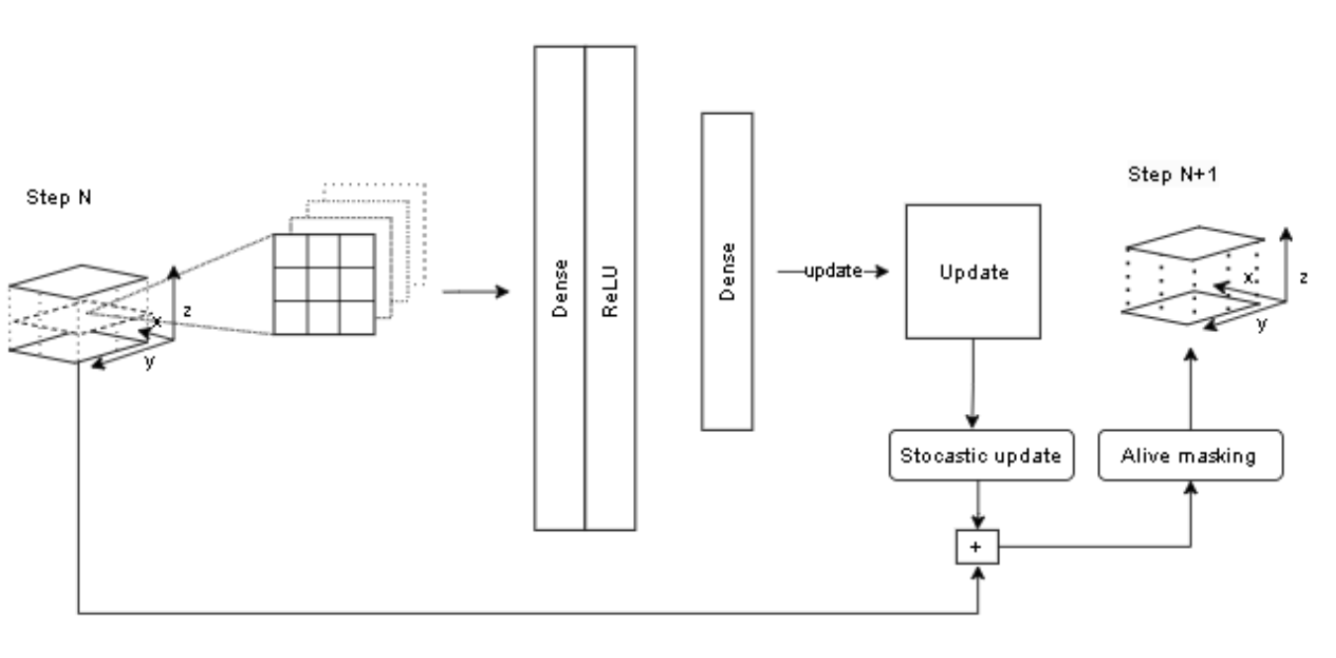

In [ ]:
#@title Building Model (no channels, only structure) DONT RUN

import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv3D
from keras.models import Sequential, load_model

class CA(tf.Module):
  def __init__(self):
    self.model=tf.keras.Sequential([
        Conv3D(filters=SIZE_Z*3, kernel_size=3, padding='same', activation=tf.nn.relu),
        Conv3D(filters=SIZE_Z, kernel_size=3,padding='same',activation=tf.nn.relu),
        Conv3D(filters=1, kernel_size=1,padding='same', kernel_initializer=tf.zeros) 
    ])
  
  @tf.function
  def __call__(self,x):
    update_mask=tf.floor(tf.random.uniform(x.shape)+0.5)
    return x+self.model(x)*update_mask



In [ ]:
#@title Building Model  (3d) multi channel

import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv3D
from keras.models import Sequential, load_model

def get_living_mask(x):
  alpha = x[..., 3:4]
  return  tf.cast(tf.nn.max_pool3d(alpha,3,1,'SAME') > 0.1,tf.float32)

class CA(tf.Module):
  def __init__(self):
    self.model=tf.keras.Sequential([
        Conv3D(filters=Channel*3, kernel_size=3, padding='same',input_shape=(SIZE_X,SIZE_Y,SIZE_Z,Channel), activation=tf.nn.relu),
        Conv3D(filters=Channel, kernel_size=3, padding='same',kernel_initializer=tf.zeros),
    ])
  
  @tf.function
  def __call__(self,x):
    #alive_mask= get_living_mask(x)
    update_mask = tf.floor(tf.random.uniform(x.shape) + 0.5)
    x= x+self.model(x)*update_mask
    #x *= alive_mask
    return x


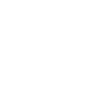

chanel 0


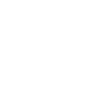

Channel 7


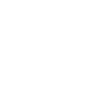

chanel 9
(15, 28, 28, 4)


In [ ]:
#@title Running randomly initialized CA for some ittirations{vertical-output:true}
ca=CA()
x=seed

ittiration=100
for i in range(ittiration):
  x=ca(x)
  if i%20==0:
    clear_output(True)
    temp = x[0][...,:4]
    imshow(zoom(temp[0][...,:4]))
    print('chanel 0')
    imshow(zoom(temp[7][...,:4]))
    print('Channel 7')
  
    imshow(zoom(temp[9][...,:4]))
    print('chanel 9')
    print(temp.shape)

In [ ]:
#@title Model summary 
ca.model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 28, 28, 72)    46728     
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 28, 28, 24)    46680     
                                                                 
Total params: 93,408
Trainable params: 93,408
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#@title Test / Visualize loss minimization

trainer=tf.optimizers.Adam(1e-3)

ittiration =10

for k in range(ittiration):
  with tf.GradientTape() as g:
    x=seed    
    print("Target ")   
    imshow(zoom(target[7][...,3]))
    print("NCA in ittiration:"+str(k))     
    
    for i in range(100): 
      x=ca(x)
      loss = tf.reduce_mean(tf.square(x[...,:4] - tf.cast(target, tf.float32)))
      if i %20==0:
        imshow(zoom(x[0][...,3][7]))
    clear_output(True)
      
  params=ca.trainable_variables
  grads=g.gradient(loss, params) 
  #grads=[g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads,params))
  print(loss.numpy())

Training scheme
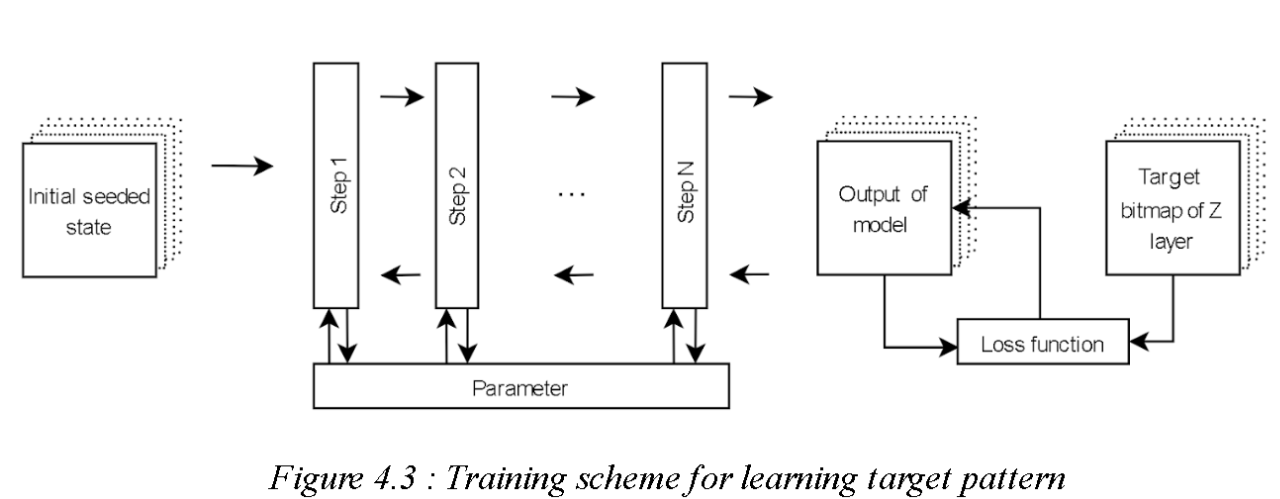


In [ ]:
#@title Defining loss & train step

#defining optimizer
lr=tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000],[1e-3,3e-4])
trainer=tf.optimizers.Adam(lr)
loss_log=[]
mse_loss = tf.keras.losses.MeanSquaredError()
@tf.function
def training_step():
  with tf.GradientTape() as g:
    BATCH_SIZE = 4 #@param {type:"slider", min:1, max:8, step:1}
    x=tf.repeat(seed,BATCH_SIZE,0)
    N="100"#@param[50,100,200]
    ittiration =int(N)
    for i in range(ittiration):
      x=ca(x)
      #loss = tf.reduce_mean(tf.square(x - target_tensor))
      #loss = tf.reduce_mean(tf.square(x[0][...,0] - trgt))
      #loss = tf.reduce_mean(tf.square(x[0][...,:1] - tf.cast(target[...,:1], tf.float32)))
      if flag:
        loss = mse_loss(x[..., :4], tf.cast(target, tf.float32))
      else:
        loss = mse_loss(x[..., :4][...,3], tf.cast(target[...,3], tf.float32))  

      #loss = tf.reduce_mean(tf.square(x[...,:4] - tf.cast(target, tf.float32)))
      
  params=ca.trainable_variables
  grads=g.gradient(loss, params) 
  grads=[g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads,params))
  return loss,x

In [ ]:
#@title Refrance layer from target to compare training progerss
imshow(zoom(target[0][...,:4][...,:3]))
print()
imshow(zoom(target[7][...,:4][...,:3]))
print()
imshow(zoom(target[9][...,:4][...,:3]))
   

Target :


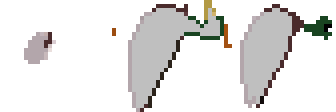

Batch : 0 layer 0,7,9


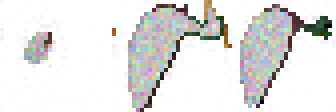

Batch : 1 layer 0,7,9


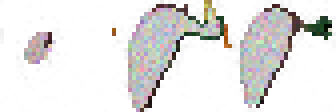

Batch : 2 layer 0,7,9


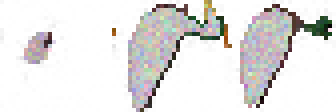

Batch : 3 layer 0,7,9


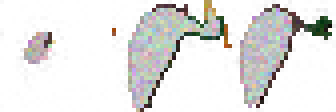

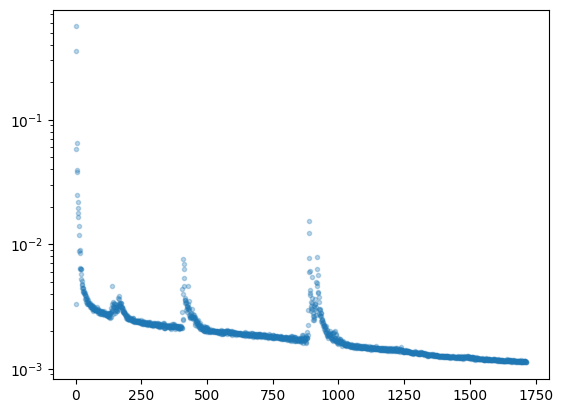

980 0.0011199182


In [ ]:

#@title Training loop {vertical-output:true}
TRAINING_ITTIRATION="1000"#@param[1000,3000,5000,10000]
 
for i in range(int(TRAINING_ITTIRATION)):
  loss,x=training_step()
  
  
  loss_log.append(loss.numpy())
  if i%20==0:
    clear_output(True)
    #print("Target :")
    #imshow(zoom(np.hstack((target[0, ..., :4],target[7, ..., :4],target[9, ..., :4]))))
 
    for n in range (4):
      temp=temp = x[n][...,:4]
      print("Batch :",n,"layer 0,7,9")
      imshow(zoom(np.hstack((temp[0], temp[7], temp[9]))))
      
    print()
    pl.plot(loss_log,'.',alpha=0.3)
    pl.yscale('log')
    pl.show()
    print(i,loss.numpy(),flush=True)

In [ ]:
#@title Save the trained model
import pickle

# Save the model to a file using pickle
file_name = path.split('/')[-1].split('.')[0]
model_name ='3dNCA-'+file_name+'.pkl'
with open(model_name, 'wb') as f:
    pickle.dump(ca, f)

In [ ]:
#@title  Load the saved model from the file
import pickle
#model_name = path.split('/')[-1].split('.')[0]
model_name = "bird-c_15x28x28" #@param ["torus_19x6x19", "spider_29x10x31","bird-c_15x28x28", "bird_26x14x27", "virus_35x34x35"]

file_path = '/content/drive/MyDrive/voxel/models/3dGNCA-'+model_name+".pkl"
file_path='/content/3dNCA-bird-c_15x28x28.pkl'
print(file_path)
with open(file_path ,'rb') as f:
    GNCA = pickle.load(f)

In [ ]:
#@title Run the trained model
x=seed
ittiration="100"#@param[100,200,300]
for i in range(int(ittiration)):
  x=GNCA(x)
  clear_output(True)
  temp = x[0][...,:4]
  imshow(zoom(temp[0]))
  print('chanel 0')
    
  imshow(zoom(temp[7]))
  print('Channel 7')
  
  imshow(zoom(temp[9]))
  print('chanel 9')

In [ ]:
#@title Final structure generated
fig = plt.figure(figsize=(10,10))
ax=fig.add_subplot(projection='3d')
temp = x[0][...,:4]
max=np.max(temp)
temp = np.where(temp < 0, 0, temp)
temp=temp/max
z_resized = np.pad(temp[...,3], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant')
r_resized = (np.pad(temp[...,0], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant'))
g_resized = (np.pad(temp[...,1], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant'))
b_resized = (np.pad(temp[...,2], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant'))

obj=np.stack((r_resized,g_resized,b_resized,z_resized),axis=-1)

ax=fig.add_subplot(projection='3d')
xx = np.where(z_resized < 0.1, 0, z_resized)
ax.voxels(xx, facecolors=obj[...,:3])

plt.show()
print(target.shape)

In [ ]:
#@title Visualize structure generation (plot image  of each stage)
x=seed
ittiration="100"#@param[100,200,300]
for i in range(int(ittiration)):
  x=GNCA(x)
  clear_output(True)
  
  fig = plt.figure(figsize=(10,10))
  ax=fig.add_subplot(projection='3d')
  temp = x[0][...,:4]
  max=np.max(temp)
  temp = np.where(temp < 0, 0, temp)
  temp=temp/max
  z_resized = np.pad(temp[...,3], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant')
  r_resized = (np.pad(temp[...,0], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant'))
  g_resized = (np.pad(temp[...,1], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant'))
  b_resized = (np.pad(temp[...,2], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant'))

  obj=np.stack((r_resized,g_resized,b_resized,z_resized),axis=-1)
  if i==100:
    for i in range(20):
      ax=fig.add_subplot(projection='3d')
      xx = np.where(z_resized < 0.1, 0, z_resized)
      ax.voxels(xx, facecolors=obj[...,:3])
      ax.voxels(xx, facecolors='silver')
      
      from mpl_toolkits.mplot3d import Axes3D
      ax.view_init(azim=i)

      filename = "img/voxel_plot_{}.png".format(i)
      plt.savefig(filename)

  ax=fig.add_subplot(projection='3d')
  xx = np.where(z_resized < 0.1, 0, z_resized)
  
  if flag:
    ax.voxels(xx, facecolors=obj[...,:3])
  else:
    ax.voxels(xx, facecolors=FACE_COLOR)
  
  from mpl_toolkits.mplot3d import Axes3D
  ax.view_init(azim=i)

  filename = "img/voxel_plot_{}.png".format(i)
  plt.savefig(filename)

  





In [ ]:
#@title Convertingn image sequence to video 
from moviepy.editor import ImageSequenceClip

file_list = ["img/voxel_plot_{}.png".format(i) for i in range(int(ittiration))]

clip = ImageSequenceClip(file_list, fps=6)
clip.write_videofile("growth.mp4")